In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.applications.xception import Xception, preprocess_input
from keras.datasets import cifar10
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, BatchNormalization, Flatten, Input, Dropout, GlobalAveragePooling2D, Lambda, Resizing
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 8s 0us/step


In [ ]:
print((x_train.shape, y_train.shape))
print((x_test.shape, y_test.shape))

((50000, 32, 32, 3), (50000, 1))
((10000, 32, 32, 3), (10000, 1))


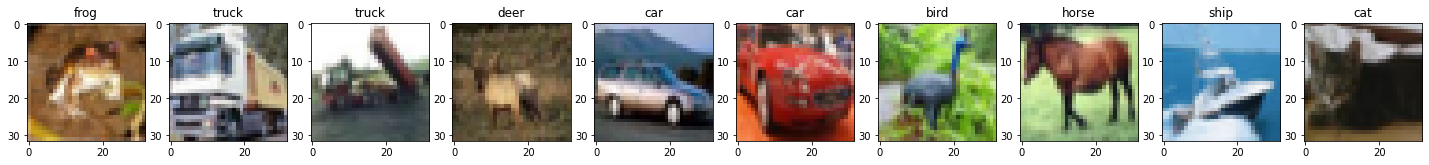

In [ ]:
names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, ax = plt.subplots(1, 10)
fig.set_figwidth(25)

for i, img in enumerate(x_train[:10]):
    ax[i].imshow(img)
    ax[i].title.set_text(names[int(y_train[i])])

In [ ]:
import imgaug as ia
import imgaug.augmenters as iaa

In [ ]:
ia.seed(42)

seq = iaa.Sequential([
    iaa.Fliplr(0.2),
    iaa.Crop(percent=(0, 0.1)),
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.1))
    ),
    iaa.Sharpen(alpha=0.2),
    iaa.LinearContrast((0.75, 1.5)),
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    iaa.Affine(
        scale={'x': (0.9, 1.1), 'y': (0.9, 1.1)},
        translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)},
        rotate=(-20, 20),
        shear=(-10, 10)
    )
], random_order=True)

augmented_x_train = seq(images=x_train)

x_train = np.concatenate([x_train, augmented_x_train])
y_train = np.concatenate([y_train, y_train])

print((x_train.shape, y_train.shape))

((100000, 32, 32, 3), (100000, 1))


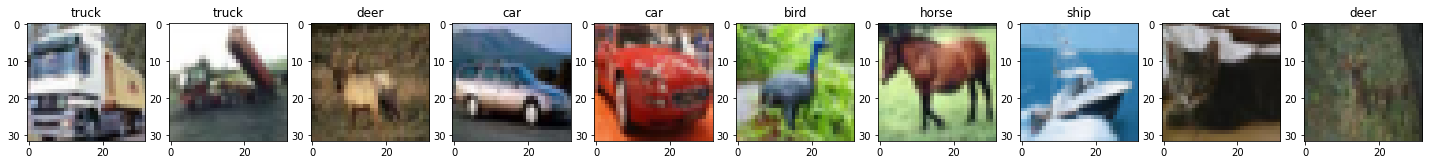

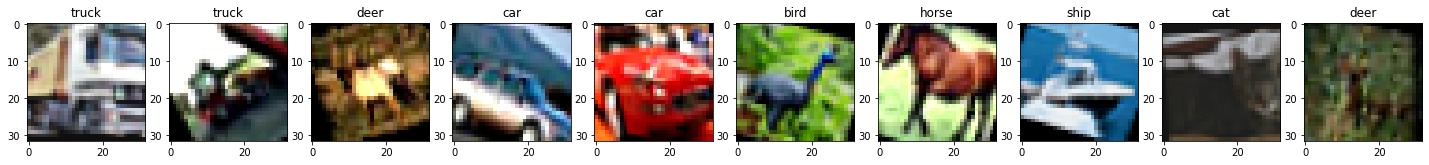

In [ ]:
fig, ax = plt.subplots(1, 10)
fig.set_figwidth(25)

for i, img in enumerate(x_train[1: 11]):
    ax[i].imshow(img)
    ax[i].title.set_text(names[int(y_train[1: 11][i])])

fig, ax = plt.subplots(1, 10)
fig.set_figwidth(25)

for i, img in enumerate(x_train[50001: 50011]):
    ax[i].imshow(img)
    ax[i].title.set_text(names[int(y_train[50001: 50011][i])])

In [ ]:
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
conv_base = Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
conv_base.trainable = True


83683744/83683744 [==============================] - 3s 0us/step


In [ ]:
conv_base.summary()

In [ ]:
inputs = Input(shape=(32, 32, 3))
x = Resizing(224, 224)(inputs)
x = preprocess_input(x)
x = conv_base(x)
x = Dropout(0.5)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001), kernel_initializer='he_uniform')(x)
x = Dropout(0.5)(x)
outputs = Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0     

In [ ]:
from keras.callbacks import ModelCheckpoint

# створюємо ModelCheckpoint callback і вказуємо шлях для збереження ваг
checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/best_weights_cifar10.h5", save_best_only=True)
chkpt = ModelCheckpoint("/content/gdrive/MyDrive/best_result_cifar10.h5",
                        monitor='val_loss',
                        verbose=1,
                        save_best_only=True,
                        mode='auto')

In [ ]:
rlrp = ReduceLROnPlateau(
    monitor='val_acc',
    factor=0.1,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    min_lr=0.00001
)
# history=model.fit(x_train,
#                   y_train,
#                   epochs=20,
#                   verbose=1,
#                   validation_data=(x_test, y_test),
#                   callbacks=[rlrp]
# )

history=model.fit(x_train, y_train, epochs=13, verbose=1, validation_split=0.1, callbacks=[rlrp, checkpoint, chkpt])

Epoch 1/13
2813/2813 [==============================] - ETA: 0s - loss: 0.6680 - accuracy: 0.8481


Epoch 1: val_loss improved from inf to 0.46918, saving model to /content/gdrive/MyDrive/best_result_cifar10.h5
2813/2813 [==============================] - 1565s 549ms/step - loss: 0.6680 - accuracy: 0.8481 - val_loss: 0.4692 - val_accuracy: 0.9038 - lr: 0.0100
Epoch 2/13
2813/2813 [==============================] - ETA: 0s - loss: 0.3300 - accuracy: 0.9511


Epoch 2: val_loss improved from 0.46918 to 0.41797, saving model to /content/gdrive/MyDrive/best_result_cifar10.h5
2813/2813 [==============================] - 1543s 549ms/step - loss: 0.3300 - accuracy: 0.9511 - val_loss: 0.4180 - val_accuracy: 0.9193 - lr: 0.0100
Epoch 3/13
2813/2813 [==============================] - ETA: 0s - loss: 0.2412 - accuracy: 0.9738


Epoch 3: val_loss improved from 0.41797 to 0.37038, saving model to /content/gdrive/MyDrive/best_result_cifar10.h5
2813/2813 [==============================] - 1544s 549ms/step - loss: 0.2412 - accuracy: 0.9738 - val_loss: 0.3704 - val_accuracy: 0.9310 - lr: 0.0100
Epoch 4/13
2813/2813 [==============================] - ETA: 0s - loss: 0.2039 - accuracy: 0.9802


Epoch 4: val_loss improved from 0.37038 to 0.34354, saving model to /content/gdrive/MyDrive/best_result_cifar10.h5
2813/2813 [==============================] - 1541s 548ms/step - loss: 0.2039 - accuracy: 0.9802 - val_loss: 0.3435 - val_accuracy: 0.9365 - lr: 0.0100
Epoch 5/13
2813/2813 [==============================] - ETA: 0s - loss: 0.1690 - accuracy: 0.9864


Epoch 5: val_loss improved from 0.34354 to 0.32303, saving model to /content/gdrive/MyDrive/best_result_cifar10.h5
2813/2813 [==============================] - 1543s 549ms/step - loss: 0.1690 - accuracy: 0.9864 - val_loss: 0.3230 - val_accuracy: 0.9395 - lr: 0.0100
Epoch 6/13
2813/2813 [==============================] - ETA: 0s - loss: 0.1481 - accuracy: 0.9894


Epoch 6: val_loss improved from 0.32303 to 0.29700, saving model to /content/gdrive/MyDrive/best_result_cifar10.h5
2813/2813 [==============================] - 1541s 548ms/step - loss: 0.1481 - accuracy: 0.9894 - val_loss: 0.2970 - val_accuracy: 0.9469 - lr: 0.0100
Epoch 7/13
2813/2813 [==============================] - ETA: 0s - loss: 0.1294 - accuracy: 0.9915


Epoch 7: val_loss improved from 0.29700 to 0.29418, saving model to /content/gdrive/MyDrive/best_result_cifar10.h5
2813/2813 [==============================] - 1542s 548ms/step - loss: 0.1294 - accuracy: 0.9915 - val_loss: 0.2942 - val_accuracy: 0.9465 - lr: 0.0100
Epoch 8/13
2813/2813 [==============================] - ETA: 0s - loss: 0.1158 - accuracy: 0.9923


Epoch 8: val_loss improved from 0.29418 to 0.27025, saving model to /content/gdrive/MyDrive/best_result_cifar10.h5
2813/2813 [==============================] - 1544s 549ms/step - loss: 0.1158 - accuracy: 0.9923 - val_loss: 0.2703 - val_accuracy: 0.9502 - lr: 0.0100
Epoch 9/13
2813/2813 [==============================] - ETA: 0s - loss: 0.1023 - accuracy: 0.9936


Epoch 9: val_loss improved from 0.27025 to 0.24243, saving model to /content/gdrive/MyDrive/best_result_cifar10.h5
2813/2813 [==============================] - 1543s 548ms/step - loss: 0.1023 - accuracy: 0.9936 - val_loss: 0.2424 - val_accuracy: 0.9564 - lr: 0.0100
Epoch 10/13
2813/2813 [==============================] - ETA: 0s - loss: 0.0895 - accuracy: 0.9953


Epoch 10: val_loss improved from 0.24243 to 0.23134, saving model to /content/gdrive/MyDrive/best_result_cifar10.h5
2813/2813 [==============================] - 1542s 548ms/step - loss: 0.0895 - accuracy: 0.9953 - val_loss: 0.2313 - val_accuracy: 0.9577 - lr: 0.0100
Epoch 11/13
2813/2813 [==============================] - ETA: 0s - loss: 0.0817 - accuracy: 0.9952


Epoch 11: val_loss did not improve from 0.23134
2813/2813 [==============================] - 1537s 546ms/step - loss: 0.0817 - accuracy: 0.9952 - val_loss: 0.2477 - val_accuracy: 0.9526 - lr: 0.0100
Epoch 12/13
2813/2813 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9954


Epoch 12: val_loss improved from 0.23134 to 0.22404, saving model to /content/gdrive/MyDrive/best_result_cifar10.h5
2813/2813 [==============================] - 1542s 548ms/step - loss: 0.0744 - accuracy: 0.9954 - val_loss: 0.2240 - val_accuracy: 0.9573 - lr: 0.0100
Epoch 13/13
2813/2813 [==============================] - ETA: 0s - loss: 0.0648 - accuracy: 0.9962


Epoch 13: val_loss did not improve from 0.22404
2813/2813 [==============================] - 1537s 546ms/step - loss: 0.0648 - accuracy: 0.9962 - val_loss: 0.2444 - val_accuracy: 0.9527 - lr: 0.0100


In [ ]:
model.save("/content/gdrive/MyDrive/model_cifal10.h5")

# Результати

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print(f'\nTest loss:{test_loss},    Test accuracy:{test_acc}')

313/313 [==============================] - 41s 130ms/step - loss: 0.2286 - accuracy: 0.9624

Test loss:0.2286377251148224,    Test accuracy:0.9624000191688538


In [ ]:
print(f"Accuracy after fitting: {history.history['accuracy'][-1]*100}%")

# For better accuracy i can increase number of epochs or i can change
# parameters on layers or i can add additional layer to the model.

Accuracy after fitting: 99.61777925491333%


In [ ]:
from keras.models import Sequential, model_from_json

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("cifar10_model.h5")
print("Saved model to disk")

Saved model to disk


# Графік

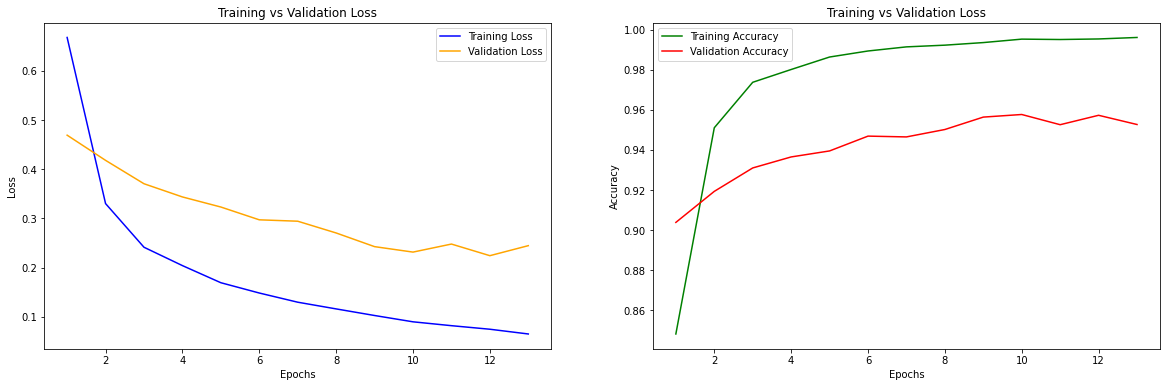

In [ ]:
#plotting  model performance

accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#Plot 1 - Training vs Validation Loss

epochs = range(1, len(loss) + 1)
epochs1 = range(1, len(accuracy) +1)


plt.figure(figsize=(20,6))

plt.subplot(1,2,2)
plt.plot(epochs1, accuracy, color="green", label='Training Accuracy')
plt.plot(epochs1, val_acc, color="red", label='Validation Accuracy')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,1)
plt.plot(epochs, loss, color="blue", label='Training Loss')
plt.plot(epochs, val_loss, color="orange", label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate The Model

In [ ]:
from sklearn.metrics import confusion_matrix

out score by giving test data we imported before

In [ ]:
# Y_test = to_categorical(Y_test, num_classes=10) # One-Hot Encoding
score = model.evaluate(x_test, y_test)
print(f"Test Loss: {score[0]*100}%")
print(f"Test Accuracy: {score[1]*100}%")

313/313 [==============================] - 40s 129ms/step - loss: 0.2286 - accuracy: 0.9624
Test Loss: 22.86377251148224%
Test Accuracy: 96.24000191688538%


313/313 [==============================] - 41s 127ms/step


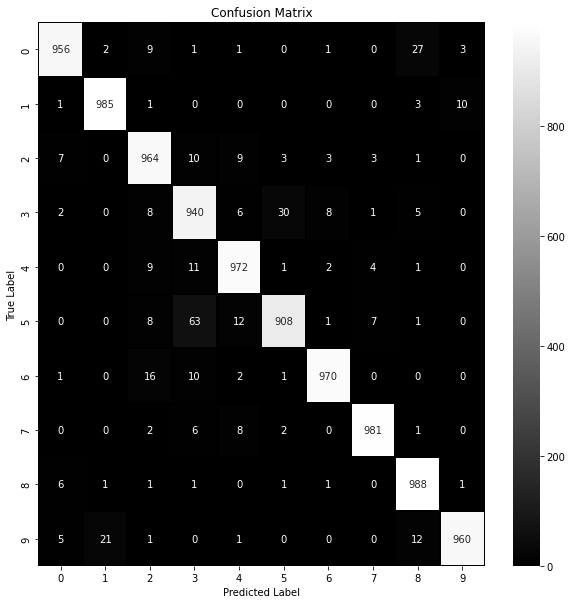

In [ ]:
Y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(y_test, axis = 1)
confusionMatrix = confusion_matrix(Y_true, Y_pred_classes)
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(confusionMatrix, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="black", fmt='.0f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
for i in range(len(confusionMatrix)):
    print(f"Class: {str(i)}")
    print(f"Number of Wrong Prediction: {str(sum(confusionMatrix[i])-confusionMatrix[i][i])} out of 1000")
    print(f"Percentage of True Prediction: {confusionMatrix[i][i] / 10}% ")
    print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")

Class: 0
Number of Wrong Prediction: 44 out of 1000
Percentage of True Prediction: 95.6% 
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 1
Number of Wrong Prediction: 15 out of 1000
Percentage of True Prediction: 98.5% 
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 2
Number of Wrong Prediction: 36 out of 1000
Percentage of True Prediction: 96.4% 
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 3
Number of Wrong Prediction: 60 out of 1000
Percentage of True Prediction: 94.0% 
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 4
Number of Wrong Prediction: 28 out of 1000
Percentage of True Prediction: 97.2% 
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 5
Number of Wrong Prediction: 92 out of 1000
Percentage of True Prediction: 90.8% 
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 6
Number of Wrong Prediction: 30 out of 1000
Percentage of True Prediction: 97.0% 
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 7
Number of Wrong Prediction: 19 out of 1000
Percentage of True Prediction: 98.1% 
<<<<<<<<<<<<<<

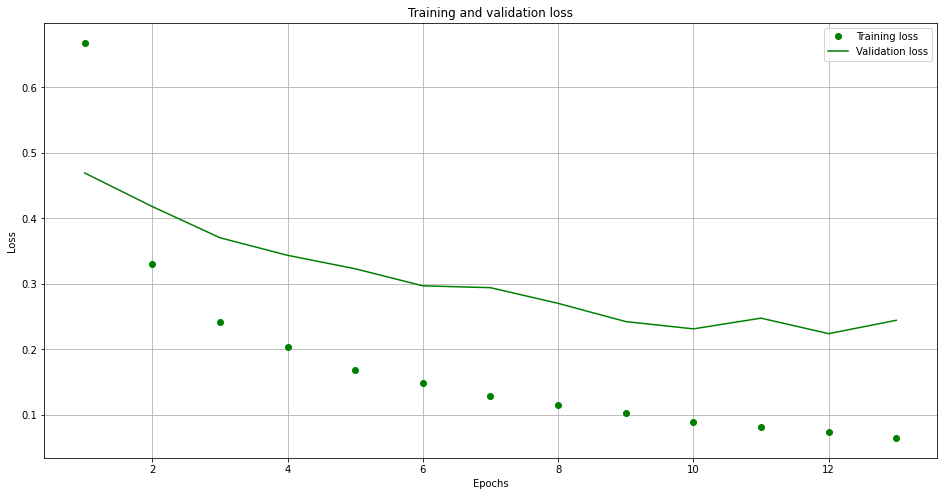

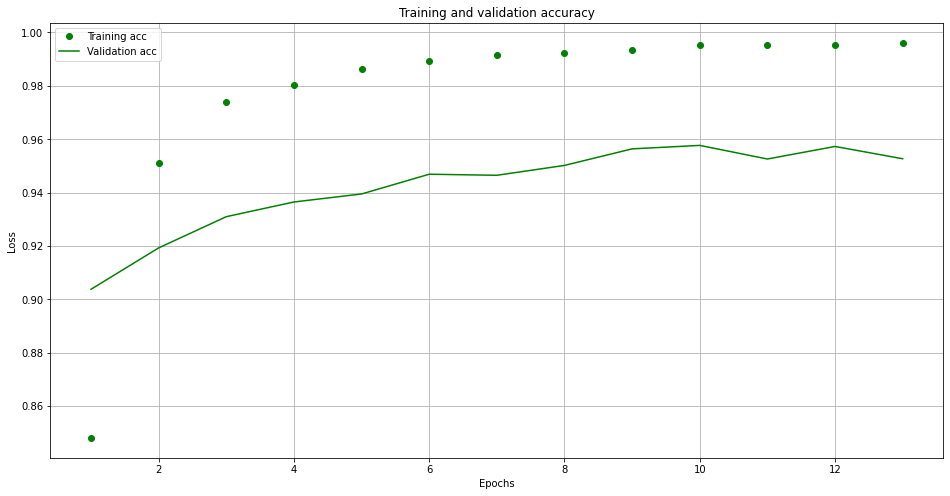

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.rcParams["figure.figsize"] = (16, 8)
plt.plot(epochs, loss_values, 'go', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(epochs, history_dict['accuracy'], 'go', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# plotting helper function
def plothist(hist):
    plt.rcParams["figure.figsize"] = (16, 8)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    plt.show()

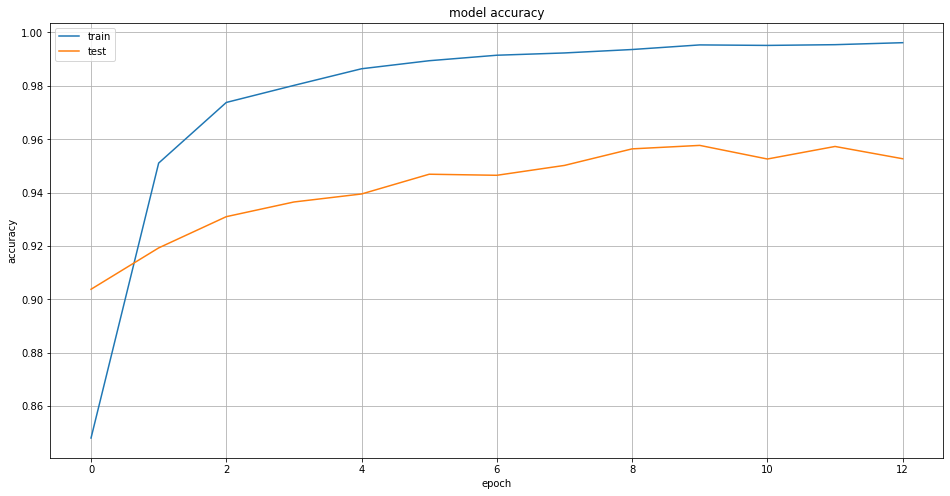

In [ ]:
plothist(history)

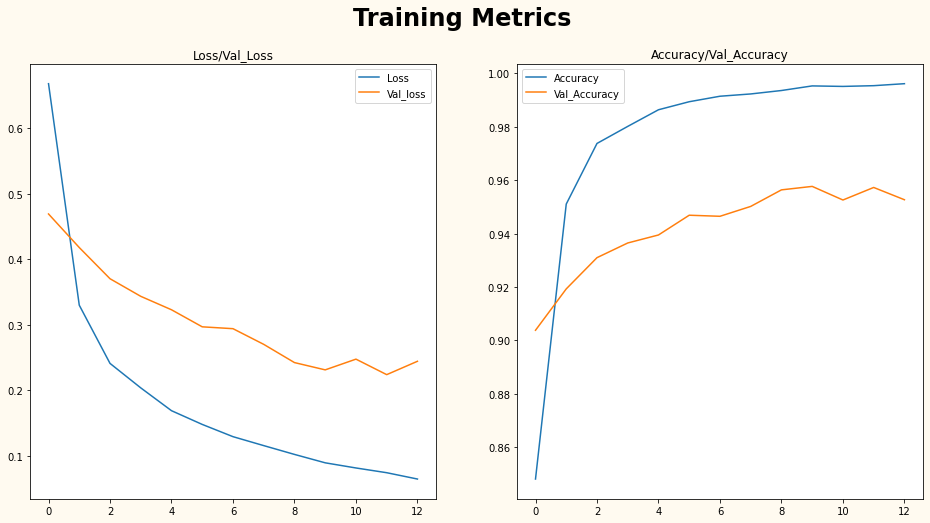

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Training Metrics', fontsize=24, fontweight='bold')
fig.set_facecolor('floralwhite')

axes[0].set_title('Loss/Val_Loss')
axes[0].plot(history.history['loss'], label='Loss')
axes[0].plot(history.history['val_loss'], label='Val_loss')
axes[0].legend()

axes[1].set_title('Accuracy/Val_Accuracy')
axes[1].plot(history.history['accuracy'], label='Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val_Accuracy')
axes[1].legend()

plt.show()


In [ ]:
model.save("/content/gdrive/MyDrive/model_cifal10_2.h5")

# Завантаження

In [ ]:
model2 = tf.keras.models.load_model('/content/model_cifal10_2.h5')

In [ ]:
# завантажуємо збережені ваги
# model2.load_weights("/content/best_weights_V.h5")

In [ ]:
# Y_test = to_categorical(Y_test, num_classes=10) # One-Hot Encoding
score = model2.evaluate(x_test, y_test)
print(f"Test Loss: {score[0]*100}%")
print(f"Test Accuracy: {score[1]*100}%")

313/313 [==============================] - 45s 142ms/step - loss: 0.2200 - accuracy: 0.9637
Test Loss: 22.004421055316925%
Test Accuracy: 96.3699996471405%


313/313 [==============================] - 44s 138ms/step


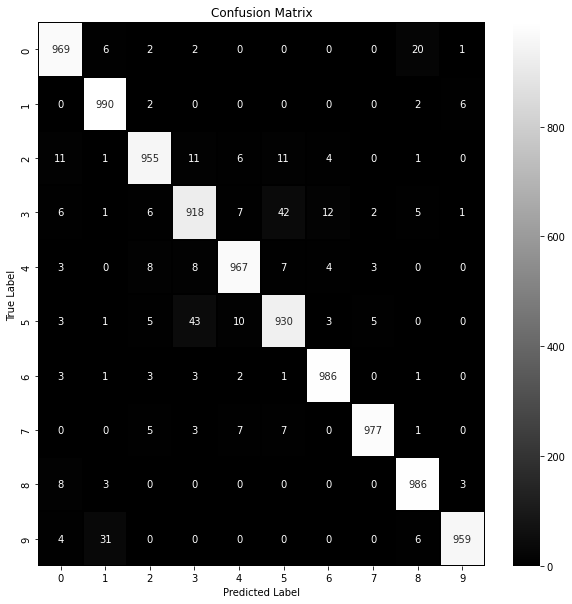

In [ ]:
Y_pred = model2.predict(x_test)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(y_test, axis = 1)
confusionMatrix = confusion_matrix(Y_true, Y_pred_classes)
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(confusionMatrix, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="black", fmt='.0f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
for i in range(len(confusionMatrix)):
    print(f"Class: {str(i)}")
    print(f"Number of Wrong Prediction: {str(sum(confusionMatrix[i])-confusionMatrix[i][i])} out of 1000")
    print(f"Percentage of True Prediction: {confusionMatrix[i][i] / 10}% ")
    print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")

Class: 0
Number of Wrong Prediction: 31 out of 1000
Percentage of True Prediction: 96.9% 
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 1
Number of Wrong Prediction: 10 out of 1000
Percentage of True Prediction: 99.0% 
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 2
Number of Wrong Prediction: 45 out of 1000
Percentage of True Prediction: 95.5% 
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 3
Number of Wrong Prediction: 82 out of 1000
Percentage of True Prediction: 91.8% 
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 4
Number of Wrong Prediction: 33 out of 1000
Percentage of True Prediction: 96.7% 
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 5
Number of Wrong Prediction: 70 out of 1000
Percentage of True Prediction: 93.0% 
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 6
Number of Wrong Prediction: 14 out of 1000
Percentage of True Prediction: 98.6% 
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Class: 7
Number of Wrong Prediction: 23 out of 1000
Percentage of True Prediction: 97.7% 
<<<<<<<<<<<<<<

# Cпроба донавчити

In [ ]:
# history2=model.fit(x_train, y_train, epochs=1, verbose=1, validation_split=0.1, callbacks=[rlrp, checkpoint])

In [ ]:
# model.save("model_best_V(5_1).h5")

In [ ]:
# # Y_test = to_categorical(Y_test, num_classes=10) # One-Hot Encoding
# score = model.evaluate(x_test, y_test)
# print(f"Test Loss: {score[0]*100}%")
# print(f"Test Accuracy: {score[1]*100}%")

In [ ]:
# Y_pred = model.predict(x_test)
# Y_pred_classes = np.argmax(Y_pred, axis = 1)
# Y_true = np.argmax(y_test, axis = 1)
# confusionMatrix = confusion_matrix(Y_true, Y_pred_classes)
# f,ax=plt.subplots(figsize=(10,10))
# sns.heatmap(confusionMatrix, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="black", fmt='.0f', ax=ax)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()

In [ ]:
# for i in range(len(confusionMatrix)):
#     print(f"Class: {str(i)}")
#     print(f"Number of Wrong Prediction: {str(sum(confusionMatrix[i])-confusionMatrix[i][i])} out of 1000")
#     print(f"Percentage of True Prediction: {confusionMatrix[i][i] / 10}% ")
#     print("<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")